# 第5回演習課題

MNISTデータの読み込み

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

In [10]:
from sklearn.metrics import f1_score
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [11]:
mnist = fetch_mldata('MNIST original')
mnist_x, mnist_y = mnist.data.astype("float32")/255.0, mnist.target.astype("int32")

train_X, test_X, train_y, test_y = train_test_split(mnist_x, mnist_y, test_size=0.2)

## 課題1：Denoising auto-encoderの実装．また，MNISTを用いて次のことを確認．
* reconstruction errorが小さくなっている（学習が進んでいる）．
* 重みの可視化（特徴の可視化）．

In [12]:
import numpy as np
import theano
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams
from collections import OrderedDict

In [13]:
rng = np.random.RandomState(1234)
theano_rng = RandomStreams(rng.randint(1234))

In [14]:
def sgd(params,gparams,lr=0.1):
    updates = OrderedDict()
    for param, gparam in zip(params, gparams):
        updates[param] = param - lr * gparam
    return updates

Autoencoderクラス

In [17]:
class Autoencoder:
    def __init__(self,visible_dim,hidden_dim,function):
        self.visible_dim = visible_dim
        self.hidden_dim = hidden_dim
        self.function = function
        
        self.W = theano.shared(rng.uniform(
                    low=-4*np.sqrt(6. / (visible_dim + hidden_dim)),
                    high=4*np.sqrt(6. / (visible_dim + hidden_dim)),
                    size=(visible_dim,hidden_dim)
                ).astype("float64"),name="W")
        
        self.a = theano.shared(np.zeros(visible_dim).astype(np.float64),name="a")
        self.b = theano.shared(np.zeros(hidden_dim).astype(np.float64),name="b")
        self.params = [self.W,self.a,self.b]
        
    #encoder
    def encode(self,x):
        u = T.dot(x, self.W)+self.b
        y = self.function(u)
        return y
    
    #decoder
    def decode(self,x):
        u = T.dot(x, self.W.T)+self.a
        y = self.function(u)
        return y
    
    #forward propagation
    def prop(self,x):
        y = self.encode(x)
        reconst_x = self.decode(y)
        return reconst_x
    
    #reconstruction error
    def reconst_error(self,x,noise):
        tilde_x = x*noise
        reconst_x = self.prop(tilde_x)
        error = T.mean(T.sum(T.nnet.binary_crossentropy(reconst_x,x),axis=1))
        return error, reconst_x

In [18]:
model = Autoencoder(train_X.shape[1],500,T.nnet.sigmoid)

x = T.matrix('x')
noise = T.matrix('noise')

cost,reconst_x = model.reconst_error(x,noise)
params  = model.params
gparams = T.grad(cost, params)
updates = sgd(params,gparams) 

train = theano.function([x,noise], [cost,reconst_x], updates=updates, allow_input_downcast=True)

In [19]:
corruption_level = 0.3
batch_size = 100
nbatches = train_X.shape[0] // batch_size

for epoch in range(10):
    train_X = shuffle(train_X)
    err_all=[]
    for i in range(0,nbatches):
        start = i * batch_size
        end   = start + batch_size
        
        noise = rng.binomial(size=train_X[start:end].shape, n=1, p=1-corruption_level)
        err,reconst_x = train(train_X[start:end],noise)
        err_all.append(err)
    print "Epoch:%d, Error:%lf" %(epoch, np.mean(err))

Epoch:0, Error:79.678105
Epoch:1, Error:75.086360
Epoch:2, Error:75.681839
Epoch:3, Error:73.602102
Epoch:4, Error:72.466965
Epoch:5, Error:71.839986
Epoch:6, Error:71.120366
Epoch:7, Error:71.675057
Epoch:8, Error:71.193216
Epoch:9, Error:68.561026


重みの可視化
* corruption_levelを変更して違いを観測

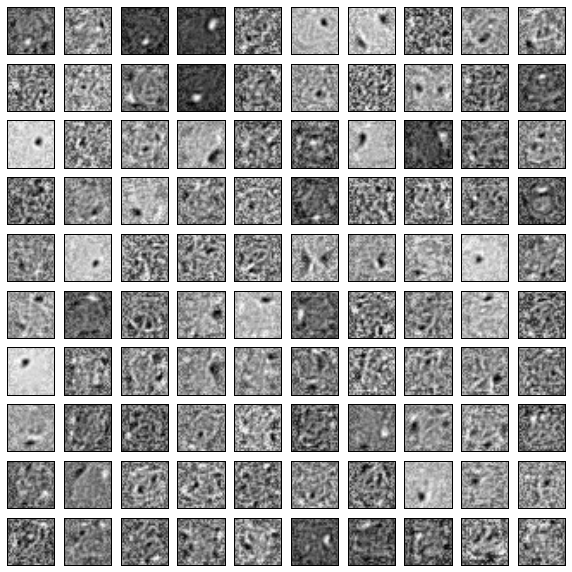

In [20]:
weight = model.W.get_value(borrow=True).T

fig = plt.figure(figsize=(10, 10))
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(weight[i].reshape((28,28)), cmap='gray')

## 課題2：RBMの実装．また，MNISTを用いて次のことを確認．
* reconstruction errorが小さくなっている（学習が進んでいる）．
* 重みの可視化（特徴の可視化）．
* 文字の生成

In [21]:
rng = np.random.RandomState(1234)
theano_rng = RandomStreams(rng.randint(1234))

RBMクラスの実装

In [22]:
class RBM:
    def __init__(self,visible_dim,hidden_dim,function,k):
        self.visible_dim = visible_dim
        self.hidden_dim = hidden_dim
        self.function = function
        self.k = k
        
        self.W = theano.shared(rng.uniform(
                    low=-4*np.sqrt(6. / (visible_dim + hidden_dim)),
                    high=4*np.sqrt(6. / (visible_dim + hidden_dim)),
                    size=(visible_dim,hidden_dim)
                ).astype("float64"),name="W")
        self.a = theano.shared(np.zeros(visible_dim).astype("float64"),name="a")
        self.b = theano.shared(np.zeros(hidden_dim).astype("float64"),name="b")
        
        self.params = [self.W,self.a,self.b]
        
    def propup(self,input):
        y = T.dot(input,self.W) + self.b
        output = self.function(y)
        return output
    
    def propdown(self,input):
        y = T.dot(input,self.W.T) + self.a
        output = self.function(y)
        return output

    #p(h|v)
    def ph_v(self,v):
        h = self.propup(v)
        h_sample = theano_rng.binomial(size=h.shape,n=1, p=h, dtype="float64")
        return h_sample,h
    
    #p(v|h)
    def pv_h(self,h):
        v = self.propdown(h)
        v_sample = theano_rng.binomial(size=v.shape,n=1, p=v, dtype="float64")
        return v_sample,v
    
    #gibbs sampling(h→v→h)
    def gibbs_hvh(self,h):
        v_sample,mean_v = self.pv_h(h)
        h_sample,mean_h = self.ph_v(v_sample)
        return h_sample,mean_h
        
    #gibbs sampling(v→h→v)
    def gibbs_vhv(self,v):
        h_sample,mean_h = self.ph_v(v)
        v_sample,mean_v = self.pv_h(h_sample)
        return v_sample,mean_v
    
    #cost(free energy)
    def free_energy(self,input):
        y = T.dot(input,self.W) + self.b
        return -T.dot(input,self.a) -T.sum(T.log(1 + T.exp(y)),axis=1)
    
    #reconstruction error
    def reconst_error(self,v):
        v_sample = v
        for k in range(self.k):
            v_sample,mean_v = model.gibbs_vhv(v_sample)
            
        cross_entropy = T.mean(T.sum(T.nnet.binary_crossentropy(mean_v,v),axis=1))
        return cross_entropy

In [23]:
x = T.matrix("x")
persistent = T.matrix("persistent")

#K(the number of gibbs sampling)
K = 1
model = RBM(train_X.shape[1],500,T.nnet.sigmoid,K)

#persistent RBM
_x = persistent
for k in range(K):
    _x,_  = model.gibbs_vhv(_x)

cost    = T.mean(model.free_energy(x)) -T.mean(model.free_energy(_x))
params  = model.params
gparams = T.grad(cost, params, consider_constant=[_x])
updates = sgd(params, gparams) 
err     = model.reconst_error(x)

train = theano.function([x,persistent], [cost,_x], updates=updates, allow_input_downcast=True)
reconst = theano.function([x], err, allow_input_downcast=True)

In [24]:
batch_size = 100
nbatches = train_X.shape[0] // batch_size

persistent = train_X.copy()
for epoch in range(10):
    train_X,persistent = shuffle(train_X,persistent)
    err_all=[]
    for i in range(0,nbatches):
        start = i * batch_size
        end   = start + batch_size
        
        cost,_x = train(train_X[start:end],persistent[start:end])
        persistent[start:end]=_x
        err = reconst(train_X[start:end])
        err_all.append(err)
    print "Epoch:%d, Error:%lf" %(epoch, np.mean(err))

Epoch:0, Error:94.805529
Epoch:1, Error:81.060047
Epoch:2, Error:78.798966
Epoch:3, Error:78.621519
Epoch:4, Error:75.040938
Epoch:5, Error:72.699270
Epoch:6, Error:76.936045
Epoch:7, Error:72.521728
Epoch:8, Error:76.520589
Epoch:9, Error:77.140334


重みの可視化

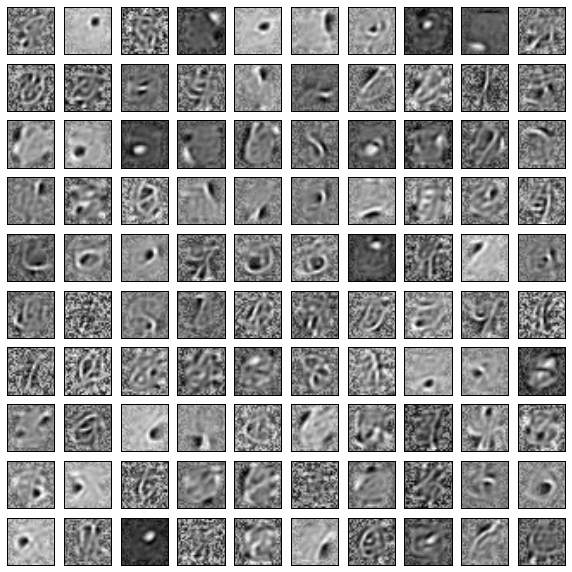

In [25]:
weight = model.W.get_value(borrow=True).T

fig = plt.figure(figsize=(10, 10))
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(weight[i].reshape((28,28)), cmap='gray')

データの生成

In [ ]:
#gibbs sampling
v = T.matrix("v")
[sample_v,mean_v],updates = theano.scan(fn=model.gibbs_vhv,outputs_info=[v,None],n_steps=1000)
sample = theano.function([v], [sample_v[-1],mean_v[-1]],updates=updates,allow_input_downcast=True)

#seed
test_X = shuffle(test_X)
sample_v,mean_v = sample(test_X[0:100])

fig = plt.figure(figsize=(10, 10))
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(mean_v[i].reshape((28,28)), cmap='gray')

## Stacked auto-encoderの実装

In [7]:
import numpy as np
import theano
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams
from collections import OrderedDict
rng = np.random.RandomState(1234)

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

from sklearn.metrics import f1_score
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist_x, mnist_y = mnist.data.astype("float32")/255.0, mnist.target.astype("int32")

以下のセルを完成させて提出

In [8]:
#Autoencoder (or RBM)
class Autoencoder:
    def __init__(self,visible_dim,hidden_dim,W,function):
        self.visible_dim = visible_dim
        self.hidden_dim = hidden_dim
        self.W = W
        self.function = function
         
        self.a = theano.shared(np.zeros(visible_dim).astype(np.float64),name="a")
        self.b = theano.shared(np.zeros(hidden_dim).astype(np.float64),name="b")
        self.params = [self.W,self.a,self.b]
        
    #encoder
    def encode(self,x):
        u = T.dot(x, self.W)+self.b
        y = self.function(u)
        return y
    
    #decoder
    def decode(self,x):
        u = T.dot(x, self.W.T)+self.a
        y = self.function(u)
        return y
    
    #forward propagation
    def prop(self,x):
        y = self.encode(x)
        reconst_x = self.decode(y)
        return reconst_x
    
    #reconstruction error
    def reconst_error(self,x,noise):
        tilde_x = x*noise
        reconst_x = self.prop(tilde_x)
        error = T.mean(T.sum(T.nnet.binary_crossentropy(reconst_x,x),axis=1))
        return error, reconst_x
        
#SGD
def sgd(params,gparams,lr=0.1):
    updates = OrderedDict()
    for param, gparam in zip(params, gparams):
        updates[param] = param - lr * gparam
    return updates
    
#Multi Layer Perceptron
class Layer:
    def __init__(self, in_dim, out_dim, function):
        ## WRITE ME Done
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.function = function
        self.W = theano.shared(
                                rng.uniform(
                                            low=-0.08, 
                                            high=0.08, 
                                            size=(in_dim, out_dim)
                                ).astype("float64"), name="W")
        self.b =  theano.shared(np.zeros(out_dim).astype("float64"), name="bias")
        
        self.params = [ self.W, self.b ]

        self.set_pretraining()

    def fprop(self, x):
        ## WRITE ME Done
        h = self.function(T.dot(x, self.W)+self.b)
        self.h = h
        return self.h

    
    def set_pretraining(self):
        ae = Autoencoder(self.in_dim,self.out_dim,self.W,self.function)

        x = T.matrix('x')
        noise = T.matrix('noise')

        cost,reconst_x = ae.reconst_error(x,noise)
        params  = ae.params
        gparams = T.grad(cost, params)
        updates = sgd(params,gparams)

        self.pretraining = theano.function([x,noise], [cost,reconst_x], updates=updates, allow_input_downcast=True)
        
        hidden = ae.encode(x)
        self.encode_function = theano.function([x], hidden, allow_input_downcast=True)

train_X, valid_X, train_y, valid_y = train_test_split(mnist_x, mnist_y, test_size=0.2, random_state=42)

activation = T.nnet.sigmoid #T.tanh

layers = [## WRITE ME Done
    Layer(784, 500, activation),
    Layer(500, 500, activation),
    Layer(500, 500, activation),
    Layer(500, 10, T.nnet.softmax)
]

#Pre-training
X = train_X
for l, layer in enumerate(layers[:-1]):
    corruption_level = 0.3 ## WRITE ME
    batch_size = 100
    nbatches = X.shape[0] // batch_size

    for epoch in range(10):
        ## WRITE ME
        X = shuffle(X)
        err_all=[]
        for i in range(0,nbatches):
            start = i * batch_size
            end   = start + batch_size

            noise = rng.binomial(size=X[start:end].shape, n=1, p=1-corruption_level)
            err,reconst_x = layer.pretraining(X[start:end],noise)
            err_all.append(err)

        print "Pre-training:: layer:%d, Epoch:%d, Error:%lf" %(l,epoch, np.mean(err_all))
    X = layer.encode_function(X)

#Fine-tuning
x, t = T.fmatrix("x"), T.ivector("t")
params = []
layer_out = None
for i, layer in enumerate(layers):
    params += layer.params
    #print i, layer_out, layer.W
    if i == 0:
        layer_out = layer.fprop(x)
    else:
        layer_out = layer.fprop(layer_out)

y = layers[-1].h
cost = - T.mean((T.log(y))[T.arange(x.shape[0]), t])

gparams = T.grad(cost, params)
updates = sgd(params,gparams)

train = theano.function([x,t], cost, updates=updates)
valid  = theano.function([x,t],[cost, T.argmax(y, axis=1)])
test  = theano.function([x],T.argmax(y, axis=1))

batch_size = 100
nbatches = train_X.shape[0]//batch_size
for epoch in range(50):
    ## WRITE ME
    train_X, train_y = shuffle(train_X, train_y)  # Shuffle Samples !!
    for i in range(nbatches):
            start = i * batch_size
            end = start + batch_size
            train(train_X[start:end], train_y[start:end])
    valid_cost, pred = valid(valid_X, valid_y)

    print "EPOCH:: %i, Validation cost: %.3f, Validation F1: %.3f"%(epoch+1, valid_cost, f1_score(valid_y, pred, average="macro"))

#pred_y = test(valid_X)

Pre-training:: layer:0, Epoch:0, Error:101.459069
Pre-training:: layer:0, Epoch:1, Error:79.938382
Pre-training:: layer:0, Epoch:2, Error:76.342781
Pre-training:: layer:0, Epoch:3, Error:74.486785
Pre-training:: layer:0, Epoch:4, Error:73.174462
Pre-training:: layer:0, Epoch:5, Error:72.175131
Pre-training:: layer:0, Epoch:6, Error:71.299969
Pre-training:: layer:0, Epoch:7, Error:70.544710
Pre-training:: layer:0, Epoch:8, Error:69.943691
Pre-training:: layer:0, Epoch:9, Error:69.375086
Pre-training:: layer:1, Epoch:0, Error:194.870496
Pre-training:: layer:1, Epoch:1, Error:176.897497
Pre-training:: layer:1, Epoch:2, Error:174.064697
Pre-training:: layer:1, Epoch:3, Error:172.439328
Pre-training:: layer:1, Epoch:4, Error:171.190407
Pre-training:: layer:1, Epoch:5, Error:170.225750
Pre-training:: layer:1, Epoch:6, Error:169.412120
Pre-training:: layer:1, Epoch:7, Error:168.746566
Pre-training:: layer:1, Epoch:8, Error:168.173964
Pre-training:: layer:1, Epoch:9, Error:167.708773
Pre-train